In [1]:
import math
import numpy as np
import math
from datasets import load_dataset
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn.preprocessing import OneHotEncoder
from SPARQLWrapper import SPARQLWrapper, JSON
import pandas as pd
import re
import json
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import pandas as pd
import os
import time
import random

/Users/alessandrococcia/Desktop/MNLP HW 1/Cultural_classification/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [59]:
silverdataset = pd.read_csv('datasets/silver.csv')
golddataset = pd.read_csv('datasets/gold.csv')

text_silver = pd.read_csv('datasets/wikipedia_text_stats_grouped_silver_links.csv')
text_gold = pd.read_csv('datasets/wikipedia_text_stats_grouped_gold_links.csv')


In [ ]:
# text_silver e text_gold preprocessing
silver_text_dataset = pd.DataFrame(text_silver)
silver_text_dataset = silver_text_dataset.drop(columns=["engtext"])
gold_text_dataset = pd.DataFrame(text_gold)
gold_text_dataset = gold_text_dataset.drop(columns=["engtext"])

compute_len = lambda x: len(x) if type(x) is not float else None
silver_text_dataset["len"] = silver_text_dataset["distribution"].apply(compute_len)
gold_text_dataset["len"] = gold_text_dataset["distribution"].apply(compute_len)

silver_text_dataset = silver_text_dataset.drop(columns="distribution")
gold_text_dataset = gold_text_dataset.drop(columns="distribution")

n_quantili = 4

# avg, std, len are categorized based on quantili
avg_bins_edges = pd.qcut(silver_text_dataset['avg'], q=n_quantili, retbins=True)[1]  # 5 intervalli uguali
std_bins_edges = pd.qcut(silver_text_dataset['std'], q=n_quantili, retbins=True)[1]  # 5 intervalli uguali
len_bins_edges = pd.qcut(silver_text_dataset['len'], q=n_quantili, retbins=True)[1]  # 5 intervalli uguali

silver_text_dataset['avg_bins'] = pd.cut(silver_text_dataset['avg'], bins=avg_bins_edges, include_lowest=True)
silver_text_dataset['std_bins'] = pd.cut(silver_text_dataset['std'], bins=std_bins_edges, include_lowest=True)
silver_text_dataset['len_bins'] = pd.cut(silver_text_dataset['len'], bins=len_bins_edges, include_lowest=True)
silver_text_dataset.dropna(subset=["len_bins"], inplace=True)

gold_text_dataset['avg_bins'] = pd.cut(gold_text_dataset['avg'], bins=avg_bins_edges, include_lowest=True)
gold_text_dataset['std_bins'] = pd.cut(gold_text_dataset['std'], bins=std_bins_edges, include_lowest=True)
gold_text_dataset['len_bins'] = pd.cut(gold_text_dataset['len'], bins=len_bins_edges, include_lowest=True)
gold_text_dataset.dropna(subset=["len_bins"], inplace=True)

# gold_text_dataset['avg_bins'] = pd.qcut(gold_text_dataset['avg'], q=n_quantili)  # 5 intervalli uguali
# gold_text_dataset['std_bins'] = pd.qcut(gold_text_dataset['std'], q=n_quantili)  # 5 intervalli uguali
# gold_text_dataset['len_bins'] = pd.qcut(gold_text_dataset['len'], q=n_quantili)  # 5 intervalli uguali

#avg, std, len are dropped
silver_text_dataset = silver_text_dataset.drop(columns=["avg", "std", "len"])
gold_text_dataset = gold_text_dataset.drop(columns=["avg", "std", "len"])



[(56.0, 134.0], (134.0, 1580.0], (4.999, 24.0], (24.0, 56.0]]
Categories (4, interval[float64, right]): [(4.999, 24.0] < (24.0, 56.0] < (56.0, 134.0] < (134.0, 1580.0]]


In [185]:
#Now we want to combine [silverdataset, silver_text_dataset] and [goldataset, gold_text_dataset] with respect to the key <entity>
silver_merged = pd.merge(silverdataset, silver_text_dataset, left_on='item', right_on='entity')
gold_merged = pd.merge(golddataset, gold_text_dataset, left_on='item', right_on='entity')

silver_merged = silver_merged.drop(columns="entity")
gold_merged = gold_merged.drop(columns="entity")

print(silver_merged.columns)

#check_for_intersection = pd.merge(silver_merged, gold_merged, on="item")
#print(len(check_for_intersection))

Index(['item', 'name', 'description', 'type', 'category', 'subcategory',
       'label', 'avg_bins', 'std_bins', 'len_bins'],
      dtype='object')


In [186]:
training_data = silver_merged
evaluation_data = gold_merged

In [149]:
def heuristic_from_text(column):
    nations = set(pd.read_csv('datasets/national_adjectives.csv')["Country"])
    national_adjectives = set(pd.read_csv('datasets/national_adjectives.csv')["Adjective"])
    
    column['new_description'] = column.apply(lambda elem: set(elem.iloc[0].split()), axis=1)
    column['length_description_intersection'] = column['new_description'].apply(lambda elem:  len(elem.intersection(national_adjectives)))
    
    column['nations'] = column['new_description'].apply(lambda elem:  len(elem.intersection(nations)))

    return column['length_description_intersection'], column['nations']

{'subcategory_mores', 'subcategory_acting style', 'subcategory_religious book', 'subcategory_happening'}


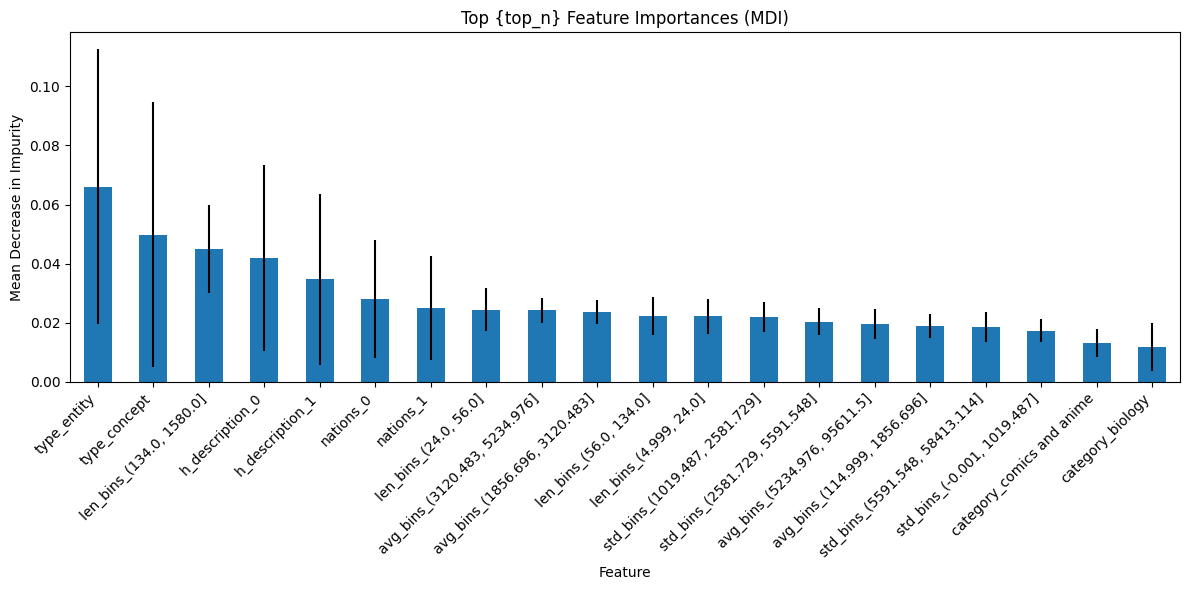

Accuratezza del modello: 0.70
f1 score del modello: 0.71


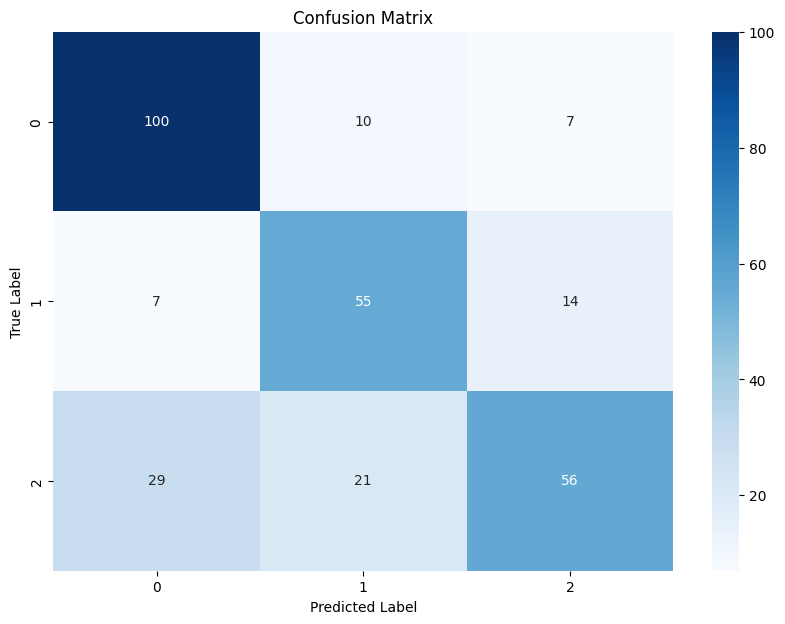

In [ ]:
# Rimuovo colonne non utili dal training set e dall'evaluation test
dataset = training_data.drop(columns=["item", "name", "description"])
evaluation_dataset = evaluation_data.drop(columns=["item", "name", "description"])

# Heuristic su 'description'
train_desc = pd.DataFrame(training_data["description"])
dataset['h_description'], dataset['nations'] = heuristic_from_text(train_desc)

# Stesso preprocessing per l'evaluation set
eval_desc = pd.DataFrame(evaluation_data["description"])
evaluation_dataset['h_description'], evaluation_dataset['nations'] = heuristic_from_text(eval_desc)

#categorie ok: h_description, category, nations, type, std_bins, avg_bins

#categorie non ok: subcategory (['mores', 'acting style', 'happening', 'religious book'] unknown)

# Colonne categoriali da codificare
categorical_columns = ["h_description", "nations", "type", "category", "subcategory", "label", "avg_bins", "std_bins", "len_bins"]

# Inizializza OneHotEncoder
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
encoder.fit(dataset[categorical_columns])

# Trasforma separatamente training e evaluation
encoded_train = encoder.transform(dataset[categorical_columns])
encoded_eval = encoder.transform(evaluation_dataset[categorical_columns])

# Crea DataFrame dalle codifiche
encoded_train_df = pd.DataFrame(encoded_train, columns=encoder.get_feature_names_out(categorical_columns), index=dataset.index)
encoded_eval_df = pd.DataFrame(encoded_eval, columns=encoder.get_feature_names_out(categorical_columns), index=evaluation_dataset.index)
# Rimuovi le colonne originali e aggiungi quelle codificate
dataset = dataset.drop(columns=categorical_columns)
dataset = pd.concat([dataset, encoded_train_df], axis=1)

evaluation_dataset = evaluation_dataset.drop(columns=categorical_columns)
evaluation_dataset = pd.concat([evaluation_dataset, encoded_eval_df], axis=1)

# Seleziono feature e target
labels = ['label_cultural agnostic', 'label_cultural exclusive', 'label_cultural representative']
X_train = dataset.drop(columns=labels)
y_train = dataset[labels]
X_test = evaluation_dataset.drop(columns=labels)
y_test = evaluation_dataset[labels]

rf_model = RandomForestClassifier(n_estimators=100, criterion='gini', random_state=42)
rf_model.fit(X_train, y_train)

# Crea i nomi delle feature (se non li hai già)
feature_names = X_train.columns.tolist()

# Calcola le importanze medie e deviazione standard tra tutti gli alberi
importances = rf_model.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf_model.estimators_], axis=0)

# Serie ordinata con le feature
forest_importances = pd.Series(importances, index=feature_names)

# Ordina e prendi le top 20
top_n = 20
top_features = forest_importances.sort_values(ascending=False).head(top_n)

# Plot
fig, ax = plt.subplots(figsize=(12, 6))
top_features.plot.bar(yerr=std[[feature_names.index(f) for f in top_features.index]], ax=ax)
ax.set_title("Top {top_n} Feature Importances (MDI)")
ax.set_ylabel("Mean Decrease in Impurity")
ax.set_xlabel("Feature")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()
 
# Predizioni sul test set
y_pred = rf_model.predict(X_test)

# Accuratezza
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average="weighted")
print(f"Accuratezza del modello: {accuracy:.2f}")
print(f"f1 score del modello: {f1:.2f}")

# Confusion matrix
cm = confusion_matrix(y_test.values.argmax(axis=1), y_pred.argmax(axis=1))
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()
